In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    #n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [4]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [5]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]

    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    print(testX)
    yhat = model.predict([testX])
    return yhat[0]

In [21]:
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, testX)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.4f, predicted=%.4f' % (testy, yhat))
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

Get Data

In [130]:
SPY_Data = yf.download('SPY', start='2020-01-01')
SPY_Data = SPY_Data['Close']
AAPL_Data = yf.download('AAPL', start='2020-01-01')
AAPL_Data = AAPL_Data['Close']
SPY_Data, AAPL_Data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


(Date
 2020-01-02    324.869995
 2020-01-03    322.410004
 2020-01-06    323.640015
 2020-01-07    322.730011
 2020-01-08    324.450012
                  ...    
 2023-06-09    429.899994
 2023-06-12    433.799988
 2023-06-13    436.660004
 2023-06-14    437.179993
 2023-06-15    440.799988
 Name: Close, Length: 870, dtype: float64,
 Date
 2020-01-02     75.087502
 2020-01-03     74.357498
 2020-01-06     74.949997
 2020-01-07     74.597504
 2020-01-08     75.797501
                  ...    
 2023-06-09    180.960007
 2023-06-12    183.789993
 2023-06-13    183.309998
 2023-06-14    183.949997
 2023-06-15    185.235001
 Name: Close, Length: 870, dtype: float64)

(<Axes: xlabel='Date'>, <Axes: xlabel='Date'>)

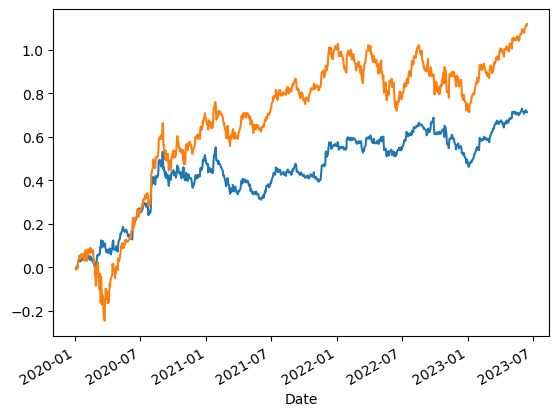

In [135]:
spy = SPY_Data.pct_change()
aapl = AAPL_Data.pct_change()
real_aapl = aapl - spy
real_aapl.cumsum().plot(), aapl.cumsum().plot()

In [1]:
#aapl = aapl / 2
pyplot.plot(aapl.cumsum(), label='AAPL')
pyplot.plot(spy.cumsum(), label='SPY')
pyplot.legend()
pyplot.show()
aapl.corr(spy)

NameError: name 'pyplot' is not defined

In [122]:
real_aapl

Date
2020-01-02         NaN
2020-01-03   -0.004880
2020-01-06   -0.001230
2020-01-07   -0.006306
2020-01-08    0.010599
                ...   
2023-06-08   -0.000235
2023-06-09    0.002910
2023-06-12    0.006412
2023-06-13    0.000760
2023-06-14    0.007933
Name: Close, Length: 869, dtype: float64

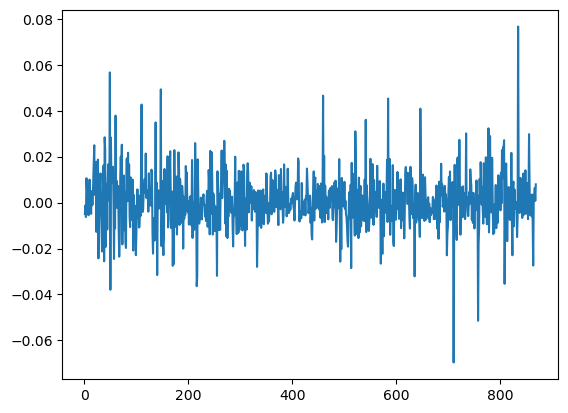

In [123]:
values = real_aapl.values
pyplot.plot(values)
pyplot.show()

In [124]:
real_data = series_to_supervised(values, n_in=15)
real_data

array([[-0.00487952, -0.00123024, -0.00630598, ...,  0.00500886,
        -0.00118374, -0.00069378],
       [-0.00123024, -0.00630598,  0.01059885, ..., -0.00118374,
        -0.00069378,  0.00911663],
       [-0.00630598,  0.01059885,  0.00571232, ..., -0.00069378,
         0.00911663,  0.01641884],
       ...,
       [ 0.00089   ,  0.00851514, -0.00720914, ..., -0.00023496,
         0.00290962,  0.00641208],
       [ 0.00851514, -0.00720914,  0.00277229, ...,  0.00290962,
         0.00641208,  0.00075979],
       [-0.00720914,  0.00277229,  0.02979799, ...,  0.00641208,
         0.00075979,  0.00793295]])

[ 0.00962939 -0.00230343  0.00320911 -0.05146339 -0.01822435 -0.01114678
  0.01030327  0.00060432  0.01759027  0.00798067 -0.00086076  0.00651363
 -0.00310114 -0.00917413  0.01711454]
>expected=-0.0022, predicted=0.0009
[-0.00230343  0.00320911 -0.05146339 -0.01822435 -0.01114678  0.01030327
  0.00060432  0.01759027  0.00798067 -0.00086076  0.00651363 -0.00310114
 -0.00917413  0.01711454 -0.00217426]
>expected=-0.0012, predicted=-0.0070
[ 0.00320911 -0.05146339 -0.01822435 -0.01114678  0.01030327  0.00060432
  0.01759027  0.00798067 -0.00086076  0.00651363 -0.00310114 -0.00917413
  0.01711454 -0.00217426 -0.00115281]
>expected=-0.0063, predicted=0.0010
[-0.05146339 -0.01822435 -0.01114678  0.01030327  0.00060432  0.01759027
  0.00798067 -0.00086076  0.00651363 -0.00310114 -0.00917413  0.01711454
 -0.00217426 -0.00115281 -0.00628288]
>expected=0.0197, predicted=0.0048
[-0.01822435 -0.01114678  0.01030327  0.00060432  0.01759027  0.00798067
 -0.00086076  0.00651363 -0.00310114 -0.0091741

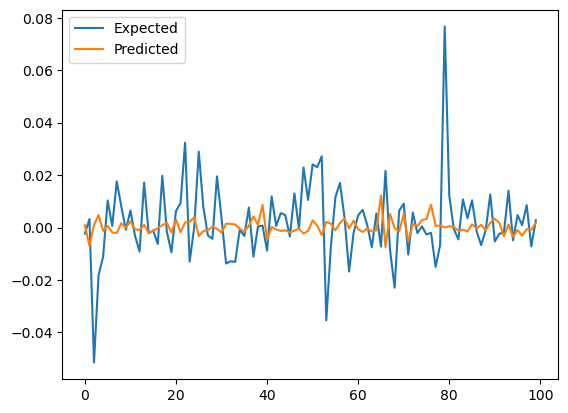

In [125]:
real_data = series_to_supervised(values, n_in=15)

mae, y, yhat = walk_forward_validation(real_data, 100)
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [126]:
print(f'MAE: {mae}')
train, aapl_test = train_test_split(real_data, 100)
aapl_test = aapl_test[:, -1]
aapl_test

MAE: 0.00981171080808869


array([-2.17425509e-03, -1.15281372e-03, -6.28288160e-03,  1.97232323e-02,
       -1.65252049e-03, -9.41479889e-03,  6.30934363e-03,  9.30686556e-03,
        3.23273079e-02, -1.29914674e-02, -4.43999417e-06,  2.89434454e-02,
        7.83271550e-03, -2.99061264e-03, -4.30616089e-03,  1.95038863e-02,
        3.59302437e-03, -1.37187922e-02, -1.28538440e-02, -1.31034825e-02,
       -8.25686098e-04, -3.21287830e-03,  7.64234687e-03, -1.11019952e-02,
        3.65939642e-04,  7.37848896e-04, -8.79336106e-03,  1.18759211e-02,
        6.08242781e-04,  5.49630676e-03,  4.73971304e-03, -3.40271594e-03,
        1.30103990e-02, -3.53412442e-04,  2.28661847e-02,  1.05257416e-02,
        2.40847531e-02,  2.29913269e-02,  2.71445951e-02, -3.53823060e-02,
       -7.43685683e-03,  1.16042070e-02,  1.70182070e-02,  3.91844418e-03,
       -1.68037356e-02, -1.91625843e-03,  4.64906654e-03,  6.76453849e-03,
        8.67524851e-04, -7.52187273e-03,  5.37397681e-03, -7.27098828e-03,
        2.16319733e-02, -

In [127]:
spy_sim = spy[-200:]
aapl = aapl[-200:]
spy_sim, aapl

(Date
 2022-08-29   -0.006612
 2022-08-30   -0.010978
 2022-08-31   -0.007609
 2022-09-01    0.003138
 2022-09-02   -0.010544
                 ...   
 2023-06-08    0.006049
 2023-06-09    0.001794
 2023-06-12    0.009072
 2023-06-13    0.006593
 2023-06-14    0.001191
 Name: Close, Length: 200, dtype: float64,
 Date
 2022-08-29   -0.010668
 2022-08-30   -0.008521
 2022-08-31   -0.005704
 2022-09-01   -0.004092
 2022-09-02   -0.016667
                 ...   
 2023-06-08    0.005814
 2023-06-09    0.004704
 2023-06-12    0.015484
 2023-06-13    0.007353
 2023-06-14    0.009124
 Name: Close, Length: 200, dtype: float64)

In [128]:
portfolio = 1000
sharpes = []
for x in range(5, 100):
    changes = []
    for i in range(1, x):
        if yhat[i] > 0:
            if aapl_test[i] > 0:
                #portfolio = ((portfolio / 2) * y[i]) + ((portfolio / 2) * spy_sim)
                changes.append(aapl_test[i])
            else:
                changes.append(aapl_test[i])
        else:
            if yhat[i] < 0:
                if aapl_test[i] < 0:
                    changes.append(-(aapl_test[i]))
                else:
                    changes.append(-(aapl_test[i]))
    changes = pd.Series(changes)
    avg_ann_rets = changes.mean() * 252
    avg_std = changes.std() * np.sqrt(252)
    sharpe = avg_ann_rets / avg_std
    sharpes.append(sharpe)
    print(f'Sharpe: {sharpe} | Rets: {avg_ann_rets} | std: {avg_std}')
sharpes = pd.Series(sharpes)
print(sharpes.mean())

Sharpe: 5.832658611065539 | Rets: 1.0234781497033056 | std: 0.1754736935505868
Sharpe: 1.917199986727153 | Rets: 0.3442766557940763 | std: 0.1795726362286232
Sharpe: 0.13027616595801653 | Rets: 0.02190478089971304 | std: 0.16814112342523335
Sharpe: -1.9342369587914428 | Rets: -0.31627163376753487 | std: 0.1635123516433834
Sharpe: 3.0675535138791568 | Rets: 0.7415725206844223 | std: 0.2417472156000457
Sharpe: 4.40349266130835 | Rets: 1.0229366625366763 | std: 0.23230120752210928
Sharpe: 4.184923472925029 | Rets: 0.9205311084298522 | std: 0.2199636658556272
Sharpe: 0.6669641869553212 | Rets: 0.17377843946843977 | std: 0.2605513802198811
Sharpe: -0.020638554900863443 | Rets: -0.005190122641670847 | std: 0.2514770373507939
Sharpe: -0.2602905531920061 | Rets: -0.06276275828042938 | std: 0.2411257631548839
Sharpe: 0.08272517224978994 | Rets: 0.01923119193423939 | std: 0.2324708599719866
Sharpe: -1.3015655899452523 | Rets: -0.3097161765366807 | std: 0.23795664154712962
Sharpe: -1.507954121313

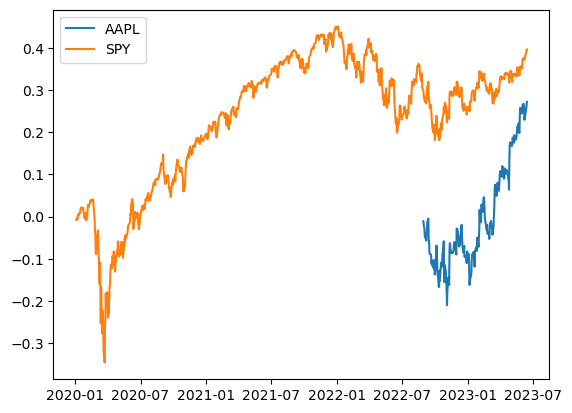

In [129]:
pyplot.plot(aapl.cumsum(), label='AAPL')
pyplot.plot(spy.cumsum(), label='SPY')
pyplot.legend()
pyplot.show()